<a href="https://colab.research.google.com/github/AriannaRampini/InverseSpectralGeometry_3DVTutorial/blob/main/3DV2021_Tutorial_ShapeFromSpectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isospectralization: how to hear shapes in PyTorch

In this short demo we will see how to recover shape deformations from the LBO spectrum using standard PyTorch autodifferentiation tools, exploiting the fact that eigendecomposition is a _differentiable_ operation.

This is part of the [3DV 2021 Tutorial](https://3dv2021.surrey.ac.uk/tutorials/) **"Spectral Geometry in practice"**.

## Mesh plot utils

In [1]:
import torch
import numpy as np
import time

In [2]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def _mesh_graph_object(pos, faces, intensity=None, scene="scene", showscale=True):
    cpu = torch.device("cpu")
    if type(pos) != np.ndarray:
      pos = pos.to(cpu).clone().detach().numpy()
    if pos.shape[-1] != 3:
      raise ValueError("Vertices positions must have shape [n,3]")
    if type(faces) != np.ndarray:
      faces = faces.to(cpu).clone().detach().numpy()
    if faces.shape[-1] != 3:
      raise ValueError("Face indices must have shape [m,3]") 
    if intensity is None:
      intensity = np.ones([pos.shape[0]])
    elif type(intensity) != np.ndarray:
      intensity = intensity.to(cpu).clone().detach().numpy()

    x, z, y = pos.T
    i, j, k = faces.T

    mesh = go.Mesh3d(x=x, y=y, z=z,
              color='lightpink',
              intensity=intensity,
              opacity=1,
              colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
              i=i, j=j, k=k,
              showscale=showscale,
              scene=scene)
    return mesh

def visualize(pos, faces, intensity=None):
    mesh   = _mesh_graph_object(pos, faces, intensity)
    layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

    #pio.renderers.default="plotly_mimetype"
    fig = go.Figure(data=[mesh],
                    layout=layout)
    fig.update_layout(
        autosize=True,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue")
    fig.show()
    return

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']]
def plot_meshes(verts,trivs,colors=None, colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']]):
    
    "Draw multiple triangle meshes side by side"
    if type(verts) is not list:
        verts=[verts]
    if type(trivs) is not list:
        trivs=[trivs]
    if colors is None:
        colors = [None for v in verts]
    if type(colors) is not list:
        colors=[colors]
        
    
    "Check device for torch tensors"
    def to_cpu(v):
        if torch.is_tensor(v):
            return v.data.cpu()
        return v;
    verts = [to_cpu(x) for x in verts]
    trivs = [to_cpu(x) for x in trivs]
    colors = [to_cpu(x) for x in colors]
        
    
    
    
    nshapes = min([len(verts),len(colors),len(trivs)])
    
    fig = make_subplots(rows=1, cols=nshapes, specs=[[{'type': 'surface'} for i in range(nshapes)]])
    for i, [vert,triv,col] in enumerate(zip(verts,trivs,colors)):
        if col is not None:
            mesh = go.Mesh3d(x=vert[:,0], z=vert[:,1], y=vert[:,2],
                            i=triv[:,0], j=triv[:,1], k=triv[:,2],
                            intensity=col,
                            colorscale= colorscale,
                            color='lightpink', opacity=1)
        else:
            mesh = go.Mesh3d(x=vert[:,0], z=vert[:,1], y=vert[:,2],
                            i=triv[:,0], j=triv[:,1], k=triv[:,2],
                            color='lightpink', opacity=1)
            
        fig.add_trace(mesh,row=1,col=i+1)        
        fig.get_subplot(1,i+1).aspectmode="data"
#     
#     fig = go.Figure(data=[mesh], layout=layout)
    fig.update_layout(
      scene=go.layout.Scene(aspectmode="data"),
      autosize=True,
      margin=dict(l=10, r=10, t=10, b=10),
      paper_bgcolor="LightSteelBlue")
    fig.show()
    return fig

## Load mesh utils

In [3]:
def read_off(str_file: str):
    file = open(str_file, 'r')
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, n_dontknow = tuple([int(s) for s in file.readline().strip().split(' ')])
    pos   = np.array([[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)])
    faces = np.array([[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)])
    return pos, faces

def write_off(pos: torch.Tensor,faces: torch.Tensor, file: str):
    #check_data(pos = pos, faces = faces)
    n, m = pos.shape[0], faces.shape[0]
    pos = pos.detach().cpu().clone().numpy();
    faces = faces.detach().cpu().clone().numpy();

    file = file if file.split(".")[-1] == "off" else file + ".off" # add suffix if necessary
    with open(file, 'w') as f:
        f.write("OFF\n")
        f.write("{} {} 0\n".format(n, m))
        for v in pos:
            f.write("{} {} {}\n".format(v[0], v[1], v[2]))
            
        for face in faces:
            f.write("3 {} {} {}\n".format(face[0],face[1],face[2]))

In [4]:
precision = 'double'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def get_pytorch_tensors(vertices, faces, precision=precision):
    vertices_torch = torch.as_tensor(vertices, 
                                     device=device,
                                     dtype=torch.double if precision == 'double' else torch.float).clone().detach().requires_grad_(True)
    faces_torch = torch.as_tensor(faces.astype(np.int64), device=device, dtype=torch.int64)
    return vertices_torch, faces_torch 

## Eigendecomposition

In [5]:
import scipy.sparse as scisparse
from scipy.sparse import linalg as sla
import torch

class Eigsh_torch(torch.autograd.Function):
    # Reference issue
    # https://github.com/pytorch/pytorch/issues/24185

    @staticmethod
    def forward(ctx, A, values=None, indices=None, k=None, sigma=-1e-5, maxiter=None, tol=0):
        # Currently using scipy, on cpu, as backend
        # (torch.symeig computes all eigenvalues only on dense tensors)
        #
        # todo: check if CuPy will support eigsh:
        # https://docs-cupy.chainer.org/en/stable/reference/comparison.html?highlight=eigsh
        assert values is not None
        assert indices is not None
        assert k is not None

        device = A.device
        precision = A.dtype

        values = values.detach().cpu().numpy()
        indices = indices.detach().cpu().numpy()
                
        Ascipy = scisparse.coo_matrix((values, indices)).tocsc()

        e, phi = sla.eigsh(
            Ascipy,
            k,
            sigma=sigma)

        e, phi = (torch.tensor(e, dtype=precision, device=device, requires_grad=False),
                  torch.tensor(phi, dtype=precision, device=device, requires_grad=False))

        ctx.save_for_backward(phi)
        return e

    @staticmethod
    def backward(ctx, glambda):
        # Implementation reference:
        # https://github.com/pytorch/pytorch/blob/9228dd766af09017364bfaa7f88feacb7e89a154/tools/autograd/templates/Functions.cpp#L1701
        # https://people.maths.ox.ac.uk/gilesm/files/NA-08-01.pdf
        v, = ctx.saved_tensors
        device = glambda.device
        # v:                   [n, k]
        # glambda:             [k]
        # result:              [n, n]
        vt = v.transpose(-2, -1)
        
        # v @ diag(glambda) @ vt
        result = (v * glambda[None, :]) @ vt

        return result, None, None, None, None, None

In [6]:
import torch
import scipy.sparse as scisparse
from scipy.sparse import linalg as sla

def calc_tri_areas(vertices, faces):
    v1 = vertices[faces[:, 0], :]
    v2 = vertices[faces[:, 1], :]
    v3 = vertices[faces[:, 2], :]
    
    v1 = v1 - v3
    v2 = v2 - v3
    return torch.norm(torch.cross(v1, v2, dim=1), dim=1) * .5


def calc_LB_FEM(vertices, faces, device='cuda'):
    n = vertices.shape[0]
    m = faces.shape[0]
    
    angles = {}
    for i in (1.0, 2.0, 3.0):
        a = torch.fmod(torch.as_tensor(i - 1), torch.as_tensor(3.)).long()
        b = torch.fmod(torch.as_tensor(i), torch.as_tensor(3.)).long()
        c = torch.fmod(torch.as_tensor(i + 1), torch.as_tensor(3.)).long()

        ab = vertices[faces[:,b],:] - vertices[faces[:,a],:];
        ac = vertices[faces[:,c],:] - vertices[faces[:,a],:];

        ab = torch.nn.functional.normalize(ab, p=2, dim=1)
        ac = torch.nn.functional.normalize(ac, p=2, dim=1)
        
        o = torch.mul(ab, ac)
        o = torch.sum(o, dim=1)
        o = torch.acos(o)
        o = torch.div(torch.cos(o), torch.sin(o))
        
        angles[i] = o
    
    indicesI = torch.cat((faces[:, 0], faces[:, 1], faces[:, 2], faces[:, 2], faces[:, 1], faces[:, 0]))
    indicesJ = torch.cat((faces[:, 1], faces[:, 2], faces[:, 0], faces[:, 1], faces[:, 0], faces[:, 2]))
    indices = torch.stack((indicesI, indicesJ))
    
    one_to_n = torch.arange(0, n, dtype=torch.long, device=device)
    eye_indices = torch.stack((one_to_n, one_to_n))

    values = torch.cat((angles[3], angles[1], angles[2], angles[1], angles[3], angles[2])) * 0.5

    
    stiff = torch.sparse_coo_tensor(indices=indices, dtype=values.dtype,
                                 values=-values,
                                 device=device,
                                 size=(n, n)).coalesce()
    stiff = stiff + torch.sparse_coo_tensor(indices=eye_indices, dtype=values.dtype,
                                 values=-torch.sparse.sum(stiff, dim=0).to_dense(),
                                 device=device,
                                 size=(n, n)).coalesce()
    
    areas = calc_tri_areas(vertices, faces)
    areas = areas.repeat(6) / 12.
    
    mass = torch.sparse_coo_tensor(indices=indices, dtype=values.dtype,
                             values=areas,
                             device=device,
                             size=(n, n)).coalesce()
    mass = mass + torch.sparse_coo_tensor(indices=eye_indices, dtype=values.dtype,
                                 values=torch.sparse.sum(mass, dim=0).to_dense(),
                                 device=device,
                                 size=(n, n)).coalesce()
    
    lumped_mass = torch.sparse.sum(mass, dim=1).to_dense()

    return stiff, mass, lumped_mass

def sparse_dense_mul(s, d):
    # implements point-wise product sparse * dense
    s = s.coalesce()
    i = s.indices()
    v = s.values()
    dv = d[i[0,:], i[1,:]]  # get values from relevant entries of dense matrix
    return torch.sparse.FloatTensor(i, v * dv, s.size()).coalesce()

def decomposition_torch(stiff, lumped_mass):
    # Cholesky decomposition for diagonal matrices
    lower = torch.sqrt(lumped_mass)

    # Compute inverse
    lower_inv = 1 / lower

    # todo1: when pytorch will support broadcastin on sparse tensor it will be enough:
    # C = lower_inv[None, :] * stiff * lower_inv[:, None]
    #
    # todo2: in alternative, use sparse @ stiff @ sparse when supported
    C = sparse_dense_mul(stiff, lower_inv[None, :] * lower_inv[:, None])  # <- INEFFICIENCY
    return C

def eigsh(A, values, indices, k, sigma=-1e-5):
    device = A.device
    precision = A.dtype

    values = values.detach().cpu().numpy()
    indices = indices.detach().cpu().numpy()
                
    Ascipy = scisparse.coo_matrix((values, indices)).tocsc()

    e, phi = sla.eigsh(Ascipy, k, sigma=sigma)

    return e, phi


## Load shapes

We load a human shape and a deformation of it featuring longer arms and one shorter leg. The first one will be our **source shape** $\mathcal{X}$, while the deformed one will be our **target**. Our goal is to trasform $\mathcal{X}$ into the target using the spectrum of the target alone.

The colormap on the target show the euclidean distance between the vertices of the two shapes. 

In [7]:
! git clone https://github.com/AriannaRampini/InverseSpectralGeometry_3DVTutorial.git

Cloning into 'InverseSpectralGeometry_3DVTutorial'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 51 (delta 17), reused 26 (delta 6), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [11]:
vertices, faces = read_off('/content/InverseSpectralGeometry_3DVTutorial/data/tr_reg_000.off')

### Cast the mesh to Torch tensors 
vertices_torch, faces_torch = get_pytorch_tensors(vertices, faces)

### Plot the mesh
visualize(vertices, faces)

In [13]:
vertices2, faces2 = read_off('/content/InverseSpectralGeometry_3DVTutorial/data/faust_target.off')

### Cast the mesh to Torch tensors 
vertices_torch2, faces_torch2 = get_pytorch_tensors(vertices2, faces2)

### Plot the mesh
visualize(vertices2, faces2, (vertices_torch-vertices_torch2).pow(2).sum(-1).sqrt())

First of all, let's compute the first 30 eigenvalues of each shape and compare them. Our goal is to align these two truncated spectra.

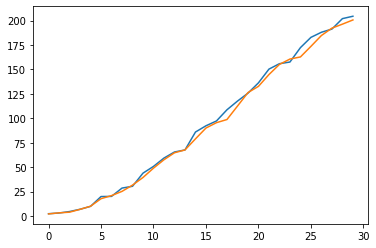

In [16]:
k_evals = 30


W, _, A = calc_LB_FEM(vertices_torch, faces_torch, device)
C = decomposition_torch(W, A)
e, phi_non_norm = eigsh(C.to_dense(), C.values(), C.indices(), k_evals+1)
A_inverse = A.rsqrt().detach().cpu().numpy()
phi = A_inverse[:,None] * phi_non_norm

W2, _, A2 = calc_LB_FEM(vertices_torch2, faces_torch2, device)
C2 = decomposition_torch(W2, A2)
e2, _ = eigsh(C2.to_dense(), C2.values(), C2.indices(), k_evals+1)

plt.figure()
plt.plot(e[1:(k_evals+1)])
plt.plot(e2[1:(k_evals+1)])

## Optimization

For numerical simplicity, we will deform the source shape using subspace parametrization. In particular, the displaced vertices $D(X)$ will be given by:

$D(X) = X + Φα$

where $X$ are the original coordinates of the vertices, $Φ$ is a $n × b$ matrix whose columns are the first $b$ Laplacian eigenfunctions of $\mathcal{X}$ (with $b ≪ n$, with $n$ is the total number of vertices), and $α$ is a $b × 3$ matrix of expansion coefficients.

We want to optimize the matrix of the coefficients $\alpha$ in order to align the spectrum of $D(X)$ to the one of our target shape.

To do this, we minimize the following weighted loss:

$\mathcal{L} = \Large || \frac{\lambda_s - \lambda_t}{\lambda_t} ||_2$

where $\lambda_s$ is the spectrum of the source shape and $\lambda_t$ is the spectrum of the target.

We call this procedure *isospectralization*.

In [17]:
### Set parameters
MAX_ITER = 500
L_RATE   = 1e-4
k_sub    = 10

### Eigenvalues and eigenvectors as tensors
target_evals = torch.as_tensor(e2[1:(k_evals+1)], device=device, dtype=torch.double if precision == 'double' else torch.float)
phi_sub = torch.as_tensor(phi[:,1:(k_sub+1)], device=device, dtype=torch.double if precision == 'double' else torch.float) ### NB first evec is just translation

### Initialize optimization variable
coeff_init = torch.zeros((k_sub,3), requires_grad=False, device="cuda", dtype=torch.double if precision == 'double' else torch.float)
coeff = coeff_init.clone().requires_grad_()

optimizer = torch.optim.Adam([coeff], lr=L_RATE)

for it in range(MAX_ITER):   
    t = time.time()
    optimizer.zero_grad()
    
    disp = torch.mm(phi_sub, coeff)
    W, _, A = calc_LB_FEM(vertices_torch + disp, faces_torch, device)
    C = decomposition_torch(W, A)
    e_it = Eigsh_torch.apply(C.to_dense(), C.values(), C.indices(), k_evals+1)

    loss = ((e_it[1:] - target_evals) / target_evals).pow(2).sum() 
    loss.backward()

    optimizer.step()

    if(loss < 1e-6):  
        break  
    
    print('%d] %.2e in %.2fs'% (it, loss.item(), time.time()-t))

0] 1.20e-01 in 0.47s
1] 1.17e-01 in 0.39s
2] 1.14e-01 in 0.40s
3] 1.10e-01 in 0.39s
4] 1.07e-01 in 0.41s
5] 1.04e-01 in 0.45s
6] 1.01e-01 in 0.41s
7] 9.83e-02 in 0.40s
8] 9.54e-02 in 0.41s
9] 9.27e-02 in 0.41s
10] 9.00e-02 in 0.42s
11] 8.74e-02 in 0.42s
12] 8.49e-02 in 0.36s
13] 8.25e-02 in 0.37s
14] 8.02e-02 in 0.36s
15] 7.80e-02 in 0.40s
16] 7.58e-02 in 0.42s
17] 7.38e-02 in 0.36s
18] 7.18e-02 in 0.41s
19] 6.99e-02 in 0.40s
20] 6.81e-02 in 0.40s
21] 6.64e-02 in 0.41s
22] 6.48e-02 in 0.40s
23] 6.32e-02 in 0.37s
24] 6.18e-02 in 0.40s
25] 6.04e-02 in 0.40s
26] 5.90e-02 in 0.37s
27] 5.78e-02 in 0.42s
28] 5.66e-02 in 0.41s
29] 5.55e-02 in 0.40s
30] 5.45e-02 in 0.39s
31] 5.35e-02 in 0.37s
32] 5.25e-02 in 0.36s
33] 5.16e-02 in 0.45s
34] 5.07e-02 in 0.41s
35] 4.98e-02 in 0.36s
36] 4.90e-02 in 0.42s
37] 4.82e-02 in 0.40s
38] 4.74e-02 in 0.36s
39] 4.67e-02 in 0.41s
40] 4.60e-02 in 0.41s
41] 4.53e-02 in 0.42s
42] 4.47e-02 in 0.36s
43] 4.41e-02 in 0.37s
44] 4.35e-02 in 0.43s
45] 4.29e-02 in 0.36

## Visualize results

Here we plot the original shape (left), our result (middle), and the target human shape (right). We can see that our *isospectralized* shape approximately encountered the desired deformation (longer arms, one leg shorter than the other). However, the upper body is modified according to a different simmetry with respect to the legs. Moreover we could not recover the exact isometry of the target since the spectrum is isometry invariant.

In [18]:
p = plot_meshes( [vertices_torch, vertices_torch+disp, vertices_torch2],
                 [faces, faces, faces2],
                 [np.ones(vertices_torch.shape[0]), disp.pow(2).sum(-1).sqrt(), (vertices_torch-vertices_torch2).pow(2).sum(-1).sqrt() ] )

Finally, we visually check the eigenvalues alignment.

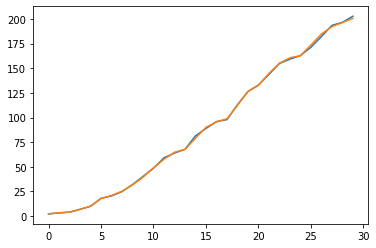

In [19]:
e_final = e_it.data.cpu().numpy()[1:(k_evals+1)]
e_target_cpu = target_evals.data.cpu().numpy()[:k_evals]

plt.figure()
plt.plot(e_final)
plt.plot(e_target_cpu)